# Projet Python ENSAE

## Tokenisation d'actifs immobiliers

Lien projet: https://hureauxarnaud.medium.com/projet-estimateur-de-prix-dun-bien-immobilier-bas%C3%A9-sur-du-machine-learning-ae578fdacaca

Code : https://colab.research.google.com/drive/1bU1Nx0HcLSSf1U6BVvsiYFfrJeKnhIW2?usp=sharing#scrollTo=GWGxYN3LKLu8   

# Etape 0 : packages

In [1]:
# importation des packages importants

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.neighbors import BallTree
import requests
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Etape 1 : preprocessing

### 1.1. Importation du dataset DVF :

Nous importons le dataset « **Demandes de valeurs foncières** » (DVF), publié par la DGFiP, permet de connaître les transactions immobilières intervenues au cours des cinq dernières années sur le territoire métropolitain et les DOM-TOM, à l’exception de l’Alsace, de la Moselle et de Mayotte. Les données contenues sont issues des actes notariés et des informations cadastrales.

Fichiers 2017-2020 : https://files.data.gouv.fr/geo-dvf/latest/

In [2]:
# Les fichiers sont issus de https://files.data.gouv.fr/geo-dvf/latest/

name = "https://files.data.gouv.fr/geo-dvf/latest/csv/2021/full.csv.gz"
table = pd.read_csv(name, sep = ',')

# Pour l'instant, on ne travaille que sur les données de 2021, mais il conviendra d'enlever les guillemets par la suite...

"""
for year in range(2017, 2021):
    name = "https://files.data.gouv.fr/geo-dvf/latest/csv/" + str(year) + "/full.csv.gz"
    table = pd.concat([table, pd.read_csv(name, sep = ',')])

display("Taille de table :")
display(table.shape)
table.head()
"""

/opt/conda/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (10,12,17,18,20,22,24,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


'\nfor year in range(2017, 2021):\n    name = "https://files.data.gouv.fr/geo-dvf/latest/csv/" + str(year) + "/full.csv.gz"\n    table = pd.concat([table, pd.read_csv(name, sep = \',\')])\n\ndisplay("Taille de table :")\ndisplay(table.shape)\ntable.head()\n'

### 1.2. Visualisation des données

A compléter : il s'agit d'avoir **des premières intuitions sur les données**. 

Notamment, il faudra visualiser sur une carte, **faire des analyses descriptives** (moyennes, variances, etc.) au niveau national et par région ou dans les grandes villes (cf. l'étape 2).

En particulier, on se rend compte du **problème de preprocessing** mentionné plus haut : une transaction correspond à plusieurs lignes.
Ainsi, si on entraîne l'algorithme de pricing sur ce dataset, il sera **biaisé** : 
* d'une part, il associerait à une dépendance de 20 m2 le prix d'un appartement de 200 m2
* d'autre part, il ne prendrait pas en compte la plus-value apportée par un jardin à une maison, par une dépendance à un appartement, etc.

Il conviendra donc de **retravailler les données pour obtenir une seule ligne par transaction**.

In [3]:
# Colonnes du dataset

print("Voici les colonnes de table :")
display(table.columns)

Voici les colonnes de table :


Index(['id_mutation', 'date_mutation', 'numero_disposition', 'nature_mutation',
       'valeur_fonciere', 'adresse_numero', 'adresse_suffixe',
       'adresse_nom_voie', 'adresse_code_voie', 'code_postal', 'code_commune',
       'nom_commune', 'code_departement', 'ancien_code_commune',
       'ancien_nom_commune', 'id_parcelle', 'ancien_id_parcelle',
       'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero',
       'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez',
       'lot4_numero', 'lot4_surface_carrez', 'lot5_numero',
       'lot5_surface_carrez', 'nombre_lots', 'code_type_local', 'type_local',
       'surface_reelle_bati', 'nombre_pieces_principales',
       'code_nature_culture', 'nature_culture', 'code_nature_culture_speciale',
       'nature_culture_speciale', 'surface_terrain', 'longitude', 'latitude'],
      dtype='object')

In [4]:
# Création d'une adresse générique

table['adresse_numero'] = table['adresse_numero'].fillna('0').astype(int)
table['adresse_suffixe'] = table['adresse_suffixe'].fillna(' ')
table['adresse_code_voie'] = table['adresse_code_voie'].fillna(' ')
table['adresse_nom_voie'] = table['adresse_nom_voie'].fillna(' ')
table['code_postal'] = table['code_postal'].fillna('0').astype(int)
table['nom_commune'] = table['nom_commune'].fillna(' ')

#Ajout de "\" pour que l'opération soit visible à l'écran en entier
table["adresse"] = table['adresse_numero'].astype(str) + ' ' + table['adresse_suffixe'] + ' ' + \
                table['adresse_code_voie'] + ' ' + table['adresse_nom_voie'] + ' ' + table['nom_commune'] + ' ' + \
                table['code_postal'].astype(str) + ' ' + 'France'

# Création d'un identifiant de transaction
# Pour identifier les doublons, l'adresse ne suffit pas : un bien peut avoir été vendu deux fois dans la même année
table["identifiant_transaction"] = table["adresse"].astype(str) + ' le ' + table["date_mutation"].astype(str)

In [5]:
# Problème dans les données et vérification de la validité de l'identifiant de transaction :

display(table["identifiant_transaction"].loc[0])
display(table["identifiant_transaction"].loc[1])
display("Si l'identifiant de transaction est valide, alors True doit s'afficher :")
table["identifiant_transaction"].loc[0] == table["identifiant_transaction"].loc[1]

'5080   0471 CHE DE VOGELAS Val-Revermont 1370 France le 2021-01-05'

'5080   0471 CHE DE VOGELAS Val-Revermont 1370 France le 2021-01-05'

"Si l'identifiant de transaction est valide, alors True doit s'afficher :"

True

**Problème de preprocessing** : le dataset affiche le même prix de vente global à chaque lot.

En effet, d'après la **notice descriptive** : 
* Les lots, notion juridique immobilière, sont définis dans un état descriptif de division (EDD) et dans les documents de mutation. Ils permettent d’identifier une partie d’un immeuble et ainsi d’y associer un droit de propriété spécifique (propriété, usufruit, etc.).
* Les locaux, notion fiscale, identifient les mêmes parties d’un immeuble pour les besoins de la taxe foncière et de la taxe d’habitation en regroupant plusieurs lots.
* La correspondance entre le découpage en lots et en locaux n’est pas retracée.

Donc, quand une disposition comporte plusieurs locaux ou plusieurs natures de culture, **le fichier de restitution comporte autant de lignes qu’il y a de locaux ou de nature de culture concernés par la mutation**. Ainsi, pour une même publication, il peut y avoir 1 à n ligne(s) de restitution. **Les données génériques (ainsi que le prix) sont alors répétées sur chaque ligne**.

Voici les types de locaux différents : 
['Dépendance', 'Appartement', 'Maison', nan, 'Local industriel. commercial ou assimilé']
On ne peut pas juste enlever les "Dépendances". En effet, ces dernières peuvent avoir un effet (haussier) sur le prix de vente.

Par ailleurs, une maison avec un jardin fait l'objet de deux lignes ayant la même valeur foncière mais des surfaces différentes (celle de la maison, celle du jardin) : suivant la colonne nature_culture ([nan, 'sols', "terrains d'agrément", 'taillis simples', 'terrains a bâtir', 'eaux', 'landes', 'taillis sous futaie', 'prés', 'terres', 'jardins', 'peupleraies', 'vignes', 'bois', 'vergers', 'carrières', 'futaies résineuses', 'pâtures', 'futaies feuillues', 'futaies mixtes', 'chemin de fer', 'oseraies', 'pacages', 'prés plantes', 'terres plantées', 'landes boisées', 'herbages', "prés d'embouche"]).

Il conviendra donc d'**agréger dans une ligne ces informations** :
* l'actif immobilier a-t-il une dépendance ? si oui, de combien de m2 ?
* la maison a-t-elle un jardin ? si oui, de combien de m2 ?

In [6]:
# On constate, encore une fois, le problème relevé ci-dessus :

display("Nombre d'adresses uniques dans le DataFrame :")
display(len(table["adresse"].unique()))

display("Nombre d'identifiant_transaction uniques dans le DataFrame :")
display(len(table["identifiant_transaction"].unique()))

display("Nombre de lignes dans le DataFrame :")
display(len(table))

display("Nombre moyen de lignes par vente :")
np.round(len(table) / len(table["identifiant_transaction"].unique()), 2)

# Une vente correspond à plusieurs lignes, les informations sont donc diffusées dans ces lignes...

"Nombre d'adresses uniques dans le DataFrame :"

547234

"Nombre d'identifiant_transaction uniques dans le DataFrame :"

654843

'Nombre de lignes dans le DataFrame :'

1210569

'Nombre moyen de lignes par vente :'

1.85

### 1.3. Création du dataset final :

Nous ne prenons que les colonnes suivantes :
- Date de vente/mutation
- Nature mutation (pour séparer les ventes en VEFA et les ventes classiques)
- Valeur foncière (prix de vente)
- Colonnes liées à l’adresse (pour nous permettre de localiser le bien)
- Adresse
- Code Postal
- Type local (maison/appartement/Local commercial/Dépendance etc)
- Surface réelle bâtie (nb de mètre carré du bien bâti)
- Surface terrain (nb de mètre carré du terrain associé au bien)

In [7]:
# Création de table_vf :

# On crée le dataframe table_vf qui sera la version finale (vf) de notre dataset
colonnes = ["date_mutation", "nature_mutation", "valeur_fonciere", "code_postal", 'type_local',
            'surface_reelle_bati', 'nombre_pieces_principales', 'nature_culture', 'surface_terrain', 'longitude', 
            'latitude', 'adresse', 'code_departement', 'identifiant_transaction']
table_vf = table[colonnes].copy()

# On agrège les types de cultures différents de NaN, sols, terrain à bâtir et  : on les renomme "culture"
culture_type = ['taillis simples', 'eaux', 'landes', 'taillis sous futaie', 'prés', 'terres', 'peupleraies', 
                'vignes', 'bois', 'vergers', 'carrières', 'futaies résineuses', 'pâtures', 'futaies feuillues', 
                'futaies mixtes', 'chemin de fer', 'oseraies', 'pacages', 'prés plantes', 'terres plantées', 
                'landes boisées', 'herbages', "prés d'embouche"]

for x in culture_type:
    table_vf.loc[table_vf["nature_culture"] == x, "nature_culture"] = "culture"

# Visualisation de table_vf
display(table_vf.shape)
display("Les quatre premières lignes")

display(table_vf.head(4))
display("Les quatre dernières lignes")

table_vf.tail(4)

(1210569, 14)

'Les quatre premières lignes'

,date_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction
0,2021-01-05,Vente,185000.0,1370,Maison,97.0,5.0,sols,2410.0,5.386094,46.327140,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,1,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...
1,2021-01-05,Vente,185000.0,1370,Dépendance,NaN,0.0,sols,2410.0,5.386094,46.327140,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,1,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...
2,2021-01-06,Vente,10.0,1290,NaN,NaN,NaN,culture,530.0,4.844368,46.224233,0 B043 ROUGEMONT Bey 1290 France,1,0 B043 ROUGEMONT Bey 1290 France le 2021-01-06
3,2021-01-04,Vente,204332.0,1310,Maison,88.0,4.0,sols,866.0,5.157688,46.200988,7 0276 ALL DES ECUREUILS Buellas 1310 France,1,7 0276 ALL DES ECUREUILS Buellas 1310 France...


'Les quatre dernières lignes'

,date_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction
1210565,2021-03-17,Vente,260000.0,75002,Appartement,37.0,2.0,NaN,NaN,2.350774,48.868450,8 8561 RUE SAINTE FOY Paris 2e Arrondissemen...,75,8 8561 RUE SAINTE FOY Paris 2e Arrondissemen...
1210566,2021-03-19,Vente,38000.0,75004,Dépendance,NaN,0.0,NaN,NaN,2.357623,48.858041,6 4398 RUE DES GUILLEMITES Paris 4e Arrondis...,75,6 4398 RUE DES GUILLEMITES Paris 4e Arrondis...
1210567,2021-03-30,Vente,38000.0,75004,Dépendance,NaN,0.0,NaN,NaN,2.365430,48.852861,30 7338 RUE DU PETIT MUSC Paris 4e Arrondiss...,75,30 7338 RUE DU PETIT MUSC Paris 4e Arrondiss...
1210568,2021-03-19,Vente,690000.0,75002,Local industriel. commercial ou assimilé,56.0,0.0,NaN,NaN,2.345110,48.868196,3 8659 RUE SAINT-JOSEPH Paris 2e Arrondissem...,75,3 8659 RUE SAINT-JOSEPH Paris 2e Arrondissem...


**1.3.1. Création de deux dataframes**

In [8]:
# On crée deux dataframes :
# * un dataframe avec les transactions non dupliquées
# * un dataframe avec les transactions dupliquées (sur lequel il faudra travailler pour parvenir à une transaction = une ligne)

table_vf_dup = table_vf.copy()
table_vf_uni = table_vf.copy()
print("Taille de table_vf_uni :")
print(table_vf_uni.shape)

# On récupère les indices des transactions dupliquées (pour lesquelles il y a 
dup_id = table_vf_dup.groupby('identifiant_transaction').size()
dup_id = dup_id[dup_id > 1]
dup_id = dup_id.reset_index()
print("Voici à quoi ressemble dup_id :")
display(dup_id.sample(3))

table_vf_dup = table_vf_dup[table_vf_dup['identifiant_transaction'].isin(dup_id["identifiant_transaction"])]
print("Voici à quoi ressemble table_vf_dup :")
display(table_vf_dup.head())
print("Taille de table_vf_dup :")
display(table_vf_dup.shape)

table_vf_uni = table_vf_uni[~table_vf_uni['identifiant_transaction'].isin(dup_id["identifiant_transaction"])]
print("Voici à quoi ressemble table_vf_uni :")
display(table_vf_uni.sample(3))
print("Taille de table_vf_uni :")
display(table_vf_uni.shape)

Taille de table_vf_uni :
(1210569, 14)
Voici à quoi ressemble dup_id :


,identifiant_transaction,0
14661,0 B003 AU-DESSUS DU BOIS DE BOHA Berzy-le-Se...,3
235929,6236 F B116 LA CURIAZ Yenne 73170 France le 20...,10
160003,22 8140 AV DE LA REPUBLIQUE Choisy-le-Roi 94...,2


Voici à quoi ressemble table_vf_dup :


,date_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction
0,2021-01-05,Vente,185000.0,1370,Maison,97.0,5.0,sols,2410.0,5.386094,46.327140,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,1,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...
1,2021-01-05,Vente,185000.0,1370,Dépendance,NaN,0.0,sols,2410.0,5.386094,46.327140,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,1,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...
4,2021-01-06,Vente,320000.0,1250,Maison,168.0,5.0,sols,1426.0,5.273260,46.156334,87 0140 RTE DE CERTINES Montagnat 1250 France,1,87 0140 RTE DE CERTINES Montagnat 1250 Franc...
5,2021-01-06,Vente,320000.0,1250,Dépendance,NaN,0.0,sols,1426.0,5.273260,46.156334,87 0140 RTE DE CERTINES Montagnat 1250 France,1,87 0140 RTE DE CERTINES Montagnat 1250 Franc...
7,2021-01-04,Vente,176000.0,1000,Dépendance,NaN,0.0,NaN,NaN,5.200117,46.210292,210 0820 RUE GEORGE SAND Saint-Denis-lès-Bou...,1,210 0820 RUE GEORGE SAND Saint-Denis-lès-Bou...


Taille de table_vf_dup :


(823100, 14)

Voici à quoi ressemble table_vf_uni :


,date_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction
326746,2021-03-15,Vente,250000.0,33240,Maison,118.0,4.0,sols,900.0,-0.428628,44.987998,340 0123 CHE DE BAYLOT Saint-André-de-Cubzac...,33,340 0123 CHE DE BAYLOT Saint-André-de-Cubzac...
970699,2021-04-23,Vente,513000.0,84160,Maison,142.0,5.0,sols,809.0,5.338374,43.760695,5304 B016 LA JACONNE Puyvert 84160 France,84,5304 B016 LA JACONNE Puyvert 84160 France le...
920080,2021-03-11,Vente,2200.0,79150,NaN,NaN,NaN,sols,32.0,-0.522415,47.003592,1 B188 LE PLESSIS GARREAU ETUSSON Saint Maur...,79,1 B188 LE PLESSIS GARREAU ETUSSON Saint Maur...


Taille de table_vf_uni :


(387469, 14)

### Rapport de mi-parcours pre-processing :

Jusqu'ici, nous avons obtenu que :
* le dataset initial (1 210 569 lignes) comporte **des erreurs qui nous empêchent de l'exploiter directement** ;
* en effet, on distingue les transactions qui n'ont fait l'objet que d'**une seule ligne** (car il n'y avait pas de bien secondaire) des transactions qui font l'objet de **plusieurs lignes** (car il y a un ou plusieurs biens secondaires) : au total il n'y a eu que **654 843 transactions** (soit environ 1,85 lignes par transaction en moyenne).

Nous avons ainsi créé **deux datasets** :
* un dataset (**table_vf_uni**) avec uniquement les transactions n'ayant fait l'objet que d'une seule ligne (387 469 lignes) ;
* un dataset (**table_vf_dup**) avec uniquement les transactions ayant fait l'objet de plusieurs lignes (823 100 lignes).

Ainsi, nous avons désormais **deux options** :
* nous pouvons *entraîner notre algorithme de pricing sur les transactions n'ayant fait l'objet que d'une seule ligne* (cela exclut par exemple les appartements avec une cave, les maisons avec un jardin d'agrément, etc.) -> cela représente tout de même près de 400 000 transactions en 2021 (60 % des transactions environ).
* nous *continuons notre travail de preprocessing pour traiter le dataset table_vf_dup* avec les transactions dupliquées (40 % des transactions environ).

Comme le traitement du dataset des transactions dupliquées est compliqué, nous avons choisi d'**étudier les deux possibilités** :
* d'abord il conviendra de vérifier que les transactions ayant fait l'objet d'une ligne unique sont **représentatives du marché immobilier français** avant d'entraîner notre algorithme avec,
* ensuite, nous pourrons **traiter le dataset des transactions dupliquées** et réentraîner notre algorithme avec ces nouvelles données.
* nous pourrons enfin **comparer les performances des deux modèles**.

**1.3.2. Traitement du dataset de transactions dupliquées :**

In [9]:
# Visualisation des colonnes principales d'intérêt pour le preprocessing :

print("* Différentes valeurs dans 'type_local' :")
display([i for i in table_vf_dup['type_local'].unique()])

print("* Différentes valeurs dans 'nature_culture' :")
display([i for i in table_vf_dup['nature_culture'].unique()])

* Différentes valeurs dans 'type_local' :


['Maison',
 'Dépendance',
 'Appartement',
 nan,
 'Local industriel. commercial ou assimilé']

* Différentes valeurs dans 'nature_culture' :


['sols', nan, 'culture', 'terrains a bâtir', 'jardins', "terrains d'agrément"]

In [10]:
# Objectif : créer des colonnes pour stocker les valeurs des biens secondaires (jardin, terrain à bâtir, dépendance, etc.)
# On veut le nombre de m2 de la culture (s'il ne s'agit pas d'un jardin / terrain d'agrément ou d'un terrain à bâtir), 
# On veut aussi le nombre de m2 du local (une dépendance ou un local industriel, par exemple), du terrain à bâtir et du jardin

table_vf_dup["culture_m2"] = 0
table_vf_dup["jardin_m2"] = 0
table_vf_dup["terrains_a_bâtir_m2"] = 0
table_vf_dup["dependance_m2"] = 0

In [11]:
# Création d'une fonction de stockage des valeurs diffuses (faudra peut-être préciser ce qu'on veut dire par là) :

def stockage_function(table_vf, table, indexes : list, saved_line_index):
    
    # On se place sur chaque "ligne supplémentaire"
    for index in indexes:
        
        # On regarde d'abord si la nature du bien à la ligne index est la même que celle de la ligne de référence retenue
        # S'il s'agit de la même nature de bien, c'est qu'on a eu une duplication ("le fichier de restitution comportera (n x p) lignes")
        if table.loc[index, "type_local"] == table.loc[saved_line_index, "type_local"] and table.loc[index, "type_local"] != "Nan":
            return table_vf
        
        # Sinon, on continue l'exploration...
        else:
            # On regarde s'il s'agit d'une dépendance ou d'un local industriel ou commercial
            if table.loc[index, "type_local"] == "Dépendance":
                if table_vf["surface_reelle_bati"][index] != "NaN":
                    table_vf["dependance_m2"][saved_line_index] += table_vf["surface_reelle_bati"][index]
                if table_vf["surface_terrain"][index] != "NaN":
                    table_vf["dependance_m2"][saved_line_index] += table_vf["surface_terrain"][index]
            elif table_vf_dup.loc[index, "type_local"] == "Local industriel. commercial ou assimilé":
                if table_vf["surface_reelle_bati"][index] != "NaN":
                    table_vf["dependance_m2"][saved_line_index] += table_vf["surface_reelle_bati"][index]
                if table_vf["surface_terrain"][index] != "NaN":
                    table_vf["dependance_m2"][saved_line_index] += table_vf["surface_terrain"][index]
                    
            # S'il ne s'agit pas d'une dépendance ou d'un local industriel ou commercial, alors il peut s'agir :
            elif table.loc[index, "type_local"] == "NaN":
                # Dans le cas où ça augmente la surface du terrain
                if table_vf["surface_terrain"][index] != "NaN":
                    # D'un jardin
                    if table_vf["nature_culture"][index] == "terrains d'agrément":
                        table_vf["jardin_m2"][saved_line_index] += table_vf["surface_terrain"][index]
                    if table_vf["nature_culture"][index] == "jardins":
                        table_vf["jardin_m2"][saved_line_index] += table_vf["surface_terrain"][index]
                    # D'un terrain à bâtir
                    if table_vf["nature_culture"][index] == 'sols':
                        table_vf["terrains_a_bâtir_m2"][saved_line_index] += table_vf["surface_terrain"][index]
                    if table_vf["nature_culture"][index] == 'terrains a bâtir':
                        table_vf["terrains_a_bâtir_m2"][saved_line_index] += table_vf["surface_terrain"][index]
                    # D'une culture
                    if table_vf["nature_culture"][index] == 'culture':
                        table_vf["culture_m2"][saved_line_index] += table_vf["surface_terrain"][index]
                # Dans le cas où ça augmente la surface réelle du bâtiment
                elif table_vf["surface_reelle_bati"][index] != "NaN":
                    if table_vf["nature_culture"][index] == 'NaN':
                        table_vf["surface_reelle_bati"][saved_line_index] += table_vf["surface_reelle_bati"][index]
                    if table_vf["nature_culture"][index] == 'sols':
                        table_vf["surface_reelle_bati"][saved_line_index] += table_vf["surface_reelle_bati"][index]
                else:
                    return table_vf
                
        return table_vf

In [12]:
# Ici, on montre à titre d'exemple pour les 500 premières lignes de table_vf_dup...
# ... car la fonction met du temps à s'exécuter !
# Donc, pour exploiter tout le dataset, il faudra supprimer cette cellule.

table_vf_dup = table_vf_dup.copy()[:500]
display("Taille initiale du dataset :")
display(table_vf_dup.shape)

'Taille initiale du dataset :'

(500, 18)

In [13]:
# Objectif : stocker les valeurs des biens secondaires (jardin, terrain à bâtir, dépendance, etc.) dans les colonnes créées

# On parcourt tous les identifiants de transactions uniques
# On a importé tqdm pour visualiser la progression 

for identifiant in tqdm(table_vf_dup["identifiant_transaction"].unique(), desc = "Progression"):
    
    # On crée une liste d'indices pour chaque identifiant de transaction unique
    indexes = list(table_vf_dup[table_vf_dup["identifiant_transaction"] == identifiant].index.values)
        
    # L'objectif est de trouver l'indice de référence : celui d'une maison, d'un appartement, etc.
    # ... et lui ajouter des informations sur les dépendances / les cultures / les locaux
    saved_line_index = indexes[0]
    for index in indexes:
        if table_vf_dup["type_local"][index] == "Maison":
            saved_line_index = index
        elif table_vf_dup["type_local"][index] == "Appartement":
            saved_line_index = index
        
    # On prépare la liste des indices à enlever
    removed_lines_indexes = []
        
    # On enlève de indexes l'indice de la ligne de référence
    indexes.remove(saved_line_index)
        
    # On utilise la fonction de stockage
    table_vf_dup = stockage_function(table_vf_dup, table, indexes, saved_line_index)
    removed_lines_indexes.extend(indexes)
    
    # On enlève les lignes désormais inutiles dont les indices ont été stockés dans removed_lines_indexes
    if len(removed_lines_indexes) != 0:
        table_vf_dup.drop(removed_lines_indexes, 0, inplace = True)

display("Taille finale du dataset :")
display(table_vf_dup.shape)
display(table_vf_dup.head(5))

Progression:   0%|          | 0/165 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/tmp/ipykernel_258/1322038162.py:32: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  table_vf_dup.drop(removed_lines_indexes, 0, inplace = True)
/tmp/ipykernel_258/515769949.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table_vf["dependance_m2"][saved_line_index] += table_vf["surface_reelle_bati"][index]
/tmp/ipykern

'Taille finale du dataset :'

(165, 18)

,date_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction,culture_m2,jardin_m2,terrains_a_bâtir_m2,dependance_m2
0,2021-01-05,Vente,185000.0,1370,Maison,97.0,5.0,sols,2410.0,5.386094,46.327140,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,1,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,0,0,0,NaN
4,2021-01-06,Vente,320000.0,1250,Maison,168.0,5.0,sols,1426.0,5.273260,46.156334,87 0140 RTE DE CERTINES Montagnat 1250 France,1,87 0140 RTE DE CERTINES Montagnat 1250 Franc...,0,0,0,NaN
8,2021-01-04,Vente,176000.0,1000,Appartement,71.0,3.0,NaN,NaN,5.200117,46.210292,210 0820 RUE GEORGE SAND Saint-Denis-lès-Bou...,1,210 0820 RUE GEORGE SAND Saint-Denis-lès-Bou...,0,0,0,NaN
10,2021-01-07,Vente,4780.0,1340,NaN,NaN,NaN,culture,6114.0,5.161927,46.393824,0 B197 FEUSSAT Foissiat 1340 France,1,0 B197 FEUSSAT Foissiat 1340 France le 2021-...,0,0,0,0.0
18,2021-01-08,Vente,145000.0,1340,NaN,NaN,NaN,sols,431.0,5.200264,46.404948,0 B071 CHAMANDRE Foissiat 1340 France,1,0 B071 CHAMANDRE Foissiat 1340 France le 202...,0,0,0,0.0


In [14]:
# On observe que le DataFrame est désormais exploitable :

display("Observation du DataFrame :")
display(table_vf_dup.head(5))

display("Nombre d'identifiant_transaction uniques dans le DataFrame :")
display(len(table_vf_dup["identifiant_transaction"].unique()))

display("Nombre de lignes dans le DataFrame :")
display(len(table_vf_dup))

display("Nombre moyen de lignes par vente :")
np.round(len(table_vf_dup) / len(table_vf_dup["identifiant_transaction"].unique()), 2)

# Attention, lorsque la surface d'une dépendance n'est pas renseignée, il est donné NaN par défaut... 
# Comment l'algorithme interprétera-t-il ce NaN ? Il s'agit de lui donner une valeur !

'Observation du DataFrame :'

,date_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction,culture_m2,jardin_m2,terrains_a_bâtir_m2,dependance_m2
0,2021-01-05,Vente,185000.0,1370,Maison,97.0,5.0,sols,2410.0,5.386094,46.327140,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,1,5080 0471 CHE DE VOGELAS Val-Revermont 1370 ...,0,0,0,NaN
4,2021-01-06,Vente,320000.0,1250,Maison,168.0,5.0,sols,1426.0,5.273260,46.156334,87 0140 RTE DE CERTINES Montagnat 1250 France,1,87 0140 RTE DE CERTINES Montagnat 1250 Franc...,0,0,0,NaN
8,2021-01-04,Vente,176000.0,1000,Appartement,71.0,3.0,NaN,NaN,5.200117,46.210292,210 0820 RUE GEORGE SAND Saint-Denis-lès-Bou...,1,210 0820 RUE GEORGE SAND Saint-Denis-lès-Bou...,0,0,0,NaN
10,2021-01-07,Vente,4780.0,1340,NaN,NaN,NaN,culture,6114.0,5.161927,46.393824,0 B197 FEUSSAT Foissiat 1340 France,1,0 B197 FEUSSAT Foissiat 1340 France le 2021-...,0,0,0,0.0
18,2021-01-08,Vente,145000.0,1340,NaN,NaN,NaN,sols,431.0,5.200264,46.404948,0 B071 CHAMANDRE Foissiat 1340 France,1,0 B071 CHAMANDRE Foissiat 1340 France le 202...,0,0,0,0.0


"Nombre d'identifiant_transaction uniques dans le DataFrame :"

165

'Nombre de lignes dans le DataFrame :'

165

'Nombre moyen de lignes par vente :'

1.0

Il ne resterait plus qu'à **merger les deux dataframes** pour obtenir toutes les informations de l'année étudiée.

Comme le code de preprocessing est très long à exécuter pour le dataset entier (12h estimées par tqdm), nous allons **nous concentrer sur le dataset des transactions avec une seule ligne** pour l'entraînement du modèle.

In [15]:
# Il faudra modifier cette cellule par la suite ...
# ... en intégrant les transactions ayant fait l'objet de plusieurs lignes pour chaque année...

# Le df "data" est celui que l'on étudie, qui est pour l'instant seulement les lignes uniques 
data = table_vf_uni
data = data.reset_index().drop("index", axis = 1)

In [16]:
data.head()

,date_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction
0,2021-01-06,Vente,10.0,1290,NaN,NaN,NaN,culture,530.0,4.844368,46.224233,0 B043 ROUGEMONT Bey 1290 France,1,0 B043 ROUGEMONT Bey 1290 France le 2021-01-06
1,2021-01-04,Vente,204332.0,1310,Maison,88.0,4.0,sols,866.0,5.157688,46.200988,7 0276 ALL DES ECUREUILS Buellas 1310 France,1,7 0276 ALL DES ECUREUILS Buellas 1310 France...
2,2021-01-04,Vente,36.3,1250,NaN,NaN,NaN,culture,121.0,5.462947,46.256243,0 B077 COMBET MAILLET Corveissiat 1250 France,1,0 B077 COMBET MAILLET Corveissiat 1250 Franc...
3,2021-01-11,Vente,400.0,1310,NaN,NaN,NaN,culture,460.0,5.115375,46.211715,0 B085 PRE BROUILLET Montcet 1310 France,1,0 B085 PRE BROUILLET Montcet 1310 France le ...
4,2021-01-07,Vente,4780.0,1340,NaN,NaN,NaN,culture,7105.0,5.158681,46.387845,0 B013 BERARDAN Foissiat 1340 France,1,0 B013 BERARDAN Foissiat 1340 France le 2021...


### 1.4. Valeurs extrêmes :

In [17]:
def boxplot_display(data):

    fig, axs = plt.subplots(1,4)
    fig.suptitle("Boxplot des variables d'intérêt :")

    axs[0].boxplot(data[data['valeur_fonciere'].notna()]['valeur_fonciere'])
    axs[0].set(title = "Valeurs foncières")

    axs[1].boxplot(data[data['surface_reelle_bati'].notna()]['surface_reelle_bati'])
    axs[1].set(title = "Surface bati")

    axs[2].boxplot(data[data['nombre_pieces_principales'].notna()]['nombre_pieces_principales'])
    axs[2].set(title = "Nbre pièces")

    axs[3].boxplot(data[data['surface_terrain'].notna()]['surface_terrain'])
    axs[3].set(title = "Surface terrain")

    fig.tight_layout()

    plt.show()

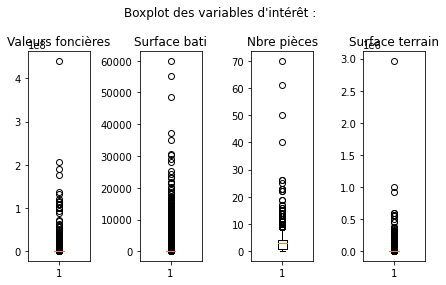

In [18]:
boxplot_display(data)

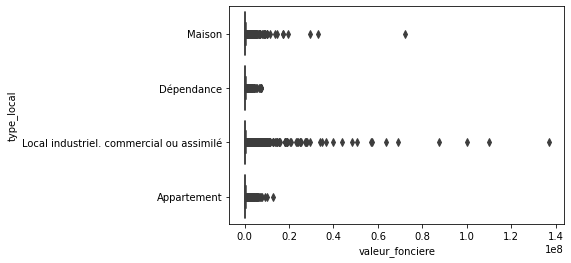

In [19]:
ax = sns.boxplot(x = "valeur_fonciere", y = "type_local", data = data)

On constate sur ces boxplots que le dataset présente des valeurs extrêmes **particulièrement basses** dans les quatre variables d'intérêt.

In [20]:
display(len(data["valeur_fonciere"]))
valeurs = [0.0, 1.0, 10.0, 1000.0, 5000.0, 10000.0]
for i in valeurs:
    display("Le nombre de valeurs foncières inférieures ou égales à "+str(i)+" est de:")
    display(sum(data["valeur_fonciere"] <= i))

387469

'Le nombre de valeurs foncières inférieures ou égales à 0.0 est de:'

0

'Le nombre de valeurs foncières inférieures ou égales à 1.0 est de:'

2315

'Le nombre de valeurs foncières inférieures ou égales à 10.0 est de:'

2500

'Le nombre de valeurs foncières inférieures ou égales à 1000.0 est de:'

13637

'Le nombre de valeurs foncières inférieures ou égales à 5000.0 est de:'

31482

'Le nombre de valeurs foncières inférieures ou égales à 10000.0 est de:'

42564

In [21]:
display(len(data["surface_reelle_bati"]))
valeurs = [0.0, 1.0, 5.0, 10.0, 30.0]
for i in valeurs:
    display("Le nombre de surfaces bati intérieures ou égales à "+str(i)+" est de:")
    display(sum(data["surface_reelle_bati"] <= i))

387469

'Le nombre de surfaces bati intérieures ou égales à 0.0 est de:'

0

'Le nombre de surfaces bati intérieures ou égales à 1.0 est de:'

21

'Le nombre de surfaces bati intérieures ou égales à 5.0 est de:'

62

'Le nombre de surfaces bati intérieures ou égales à 10.0 est de:'

496

'Le nombre de surfaces bati intérieures ou égales à 30.0 est de:'

17006

On constate que bien qu'il n'y ait pas de valeurs foncières nulle, il y en a **de nombreuses qui sont inférieures ou égales à 10**.
On considère qu'**une transaction est crédible lorsque la valeur foncière est supérieure à 1000** (en-dessous, il s'agit d'une vente qui ne nous intéresse pas).

In [22]:
# D'abord, on écarte les valeurs foncières inférieures à 5000 et les surface_reelle_bati inférieures à 10 m2

data = data[data["valeur_fonciere"] > 4999]

data = data[data["surface_reelle_bati"] > 9]

In [23]:
# Il n'y a plus de Dépendances dans le dataset...

data["type_local"].unique()

array(['Maison', 'Local industriel. commercial ou assimilé',
       'Appartement'], dtype=object)

In [24]:
data.drop(["code_postal", "longitude", "latitude"], axis = 1).describe()

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain
count,2.089620e+05,208962.000000,208962.000000,131713.000000
mean,2.453215e+05,108.507446,3.401489,579.178654
std,7.371912e+05,443.792462,1.731744,1495.270241
min,5.000000e+03,10.000000,0.000000,1.000000
25%,1.050000e+05,56.000000,2.000000,209.000000
50%,1.730000e+05,80.000000,4.000000,412.000000
75%,2.800000e+05,105.000000,4.000000,676.000000
max,1.369470e+08,60000.000000,70.000000,278931.000000


Par ailleurs, on observe avec le describe ci-dessus que **les écart-types sont très importants par rapport aux moyennes**, surtout pour les variables "valeur_fonciere", "surface_reelle_bati" et "surface_terrain".
Donc, **on enlève les valeurs trop hautes** : ici, cela consiste à *enlever les valeurs dont l'écart à la moyenne en valeur absolue est supérieure à 4 fois l'écart-type*.

In [25]:
# Pour valeur_fonciere :
data = data[~(np.abs(data['valeur_fonciere'] - data['valeur_fonciere'].mean()) > (4 * data['valeur_fonciere'].std()))]

# Pour surface_reelle_bati :
data = data[~(np.abs(data['surface_reelle_bati'] - data['surface_reelle_bati'].mean()) > (4 * data['surface_reelle_bati'].std()))]

# Pour surface_terrain :
data = data[~(np.abs(data['surface_terrain'] - data['surface_terrain'].mean()) > (4 * data['surface_terrain'].std()))]

In [26]:
data.drop(["code_postal", "longitude", "latitude"], axis = 1).describe()

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain
count,2.074130e+05,207413.000000,207413.000000,130343.000000
mean,2.275776e+05,90.073877,3.416883,508.939659
std,2.186373e+05,80.755483,1.715642,456.711799
min,5.000000e+03,10.000000,0.000000,1.000000
25%,1.050000e+05,55.000000,2.000000,207.000000
50%,1.720000e+05,80.000000,4.000000,408.000000
75%,2.780000e+05,105.000000,4.000000,666.000000
max,3.190000e+06,1609.000000,70.000000,4247.000000


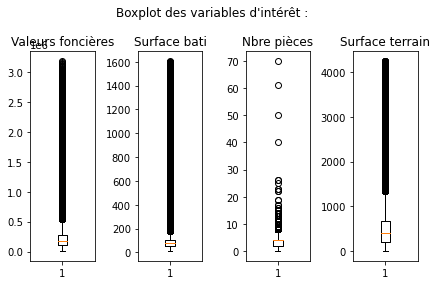

In [27]:
boxplot_display(data)

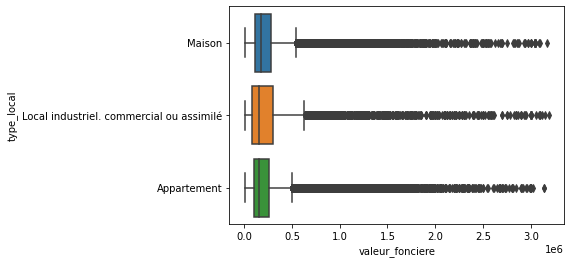

In [28]:
ax = sns.boxplot(x = "valeur_fonciere", y = "type_local", data = data)

Ces boxplots correspondent davantage avec la réalité (médiane des ventes autour de 150 000 euros).

# Etape 2 : feature engineering

Idées de features : 
* prix au m2 du quartier (BallTree), 
* PIB du département, 
* densité du département (mesure de l'urbanisation, de l'activité), 
* variation de population non naturelle (mesure de l'attractivité),
* mois de la transaction.

Un agent immobilier a besoin du **prix au m2 du quartier**, c'est une donnée importante ! Pour cela, nous allons créer ...

In [29]:
# prix_m2

data['prix_m2'] = data['surface_terrain'] / data['valeur_fonciere']

# départements

print(f"Il y a {len(data['code_departement'].unique())} départements représentés dans le dataset.")

Il y a 99 départements représentés dans le dataset.


In [30]:
# Créations des modèles BallTree

''' 
nb_departements = 99
appart_old[‘Distance moyenne’]=np.zeros(len(appart_old))
appart_old[‘Indices voisins’]=np.zeros(len(appart_old))
models={}
regions=appart_old.Région.unique()
for k in range(len(regions)):
    name=’appart_’+regions[k]
    data=appart_old[appart_old.Région==regions[k]]
    data=data.reset_index(drop=True)
    models[k]=BallTree(data[[‘latitude_r’, ‘longitude_r’]].values, leaf_size=2, metric=’haversine’)
    save_obj(models[k], name)
'''

' \nnb_departements = 99\nappart_old[‘Distance moyenne’]=np.zeros(len(appart_old))\nappart_old[‘Indices voisins’]=np.zeros(len(appart_old))\nmodels={}\nregions=appart_old.Région.unique()\nfor k in range(len(regions)):\n    name=’appart_’+regions[k]\n    data=appart_old[appart_old.Région==regions[k]]\n    data=data.reset_index(drop=True)\n    models[k]=BallTree(data[[‘latitude_r’, ‘longitude_r’]].values, leaf_size=2, metric=’haversine’)\n    save_obj(models[k], name)\n'

# Etape 3 : analyse descriptive

### 3.1. Premières analyses :

In [31]:
# Visualisation des lignes
data.head(2)

,date_mutation,nature_mutation,valeur_fonciere,code_postal,type_local,surface_reelle_bati,nombre_pieces_principales,nature_culture,surface_terrain,longitude,latitude,adresse,code_departement,identifiant_transaction,prix_m2
1,2021-01-04,Vente,204332.0,1310,Maison,88.0,4.0,sols,866.0,5.157688,46.200988,7 0276 ALL DES ECUREUILS Buellas 1310 France,1,7 0276 ALL DES ECUREUILS Buellas 1310 France...,0.004238
6,2021-01-04,Vente,226700.0,1310,Maison,96.0,3.0,NaN,NaN,5.108604,46.244066,173 0164 CHE DU MOULIN DE POLAIZE Polliat 13...,1,173 0164 CHE DU MOULIN DE POLAIZE Polliat 13...,NaN


In [32]:
display(data["nature_culture"].unique())
display(data["type_local"].unique())

array(['sols', nan, 'culture', 'terrains a bâtir', 'jardins',
       "terrains d'agrément"], dtype=object)

array(['Maison', 'Local industriel. commercial ou assimilé',
       'Appartement'], dtype=object)

In [33]:
nb_maisons = list(data["type_local"]).count("Maison")
print(f"Le nombre de maisons dans le dataset est : {nb_maisons}.")

nb_appartement = list(data["type_local"]).count("Appartement")
print(f"Le nombre d'appartments dans le dataset est : {nb_appartement}.")

nb_local = list(data["type_local"]).count("Local industriel. commercial ou assimilé")
print(f"Le nombre de 'Local industriel. commercial ou assimilé' dans le dataset est : {nb_local}.")

Le nombre de maisons dans le dataset est : 132465.
Le nombre d'appartments dans le dataset est : 63468.
Le nombre de 'Local industriel. commercial ou assimilé' dans le dataset est : 11480.


### 3.2. Analyse de la répartition des ventes :

Text(0.5, 1.0, 'Répartition des valeurs foncières')

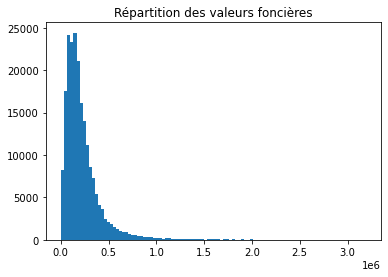

In [34]:
# Répartition des prix de vente

plt.hist(data["valeur_fonciere"].values, bins = 100)
plt.title('Répartition des valeurs foncières')

Il y a encore des valeurs extrêmes qui **gênent la visualisation**. Nous allons **renlever les valeurs extrêmes** pour pouvoir mieux observer (nous enlevons les valeurs foncières dont l'écart à la moyenne est supérieur à 2,5 fois l'écart type).

On constate que la distribution est celle d'une **loi exponentielle**.

N.B. : nous utilisons également **le package seaborn** qui offre de bonnes opportunités de visualisation.

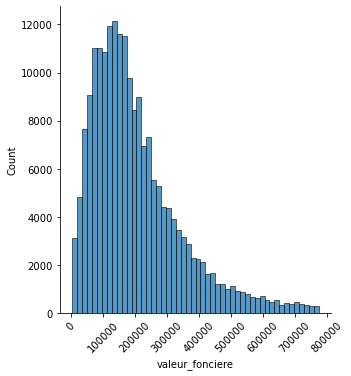

In [35]:
data_aux = data[~(np.abs(data['valeur_fonciere'] - data['valeur_fonciere'].mean()) > (2.5 * data['valeur_fonciere'].std()))]

sns.displot(data_aux, 
            x = "valeur_fonciere", 
            bins = 50)
plt.xticks(rotation = 45)
plt.show()

Distinguons les **types de biens** désormais :

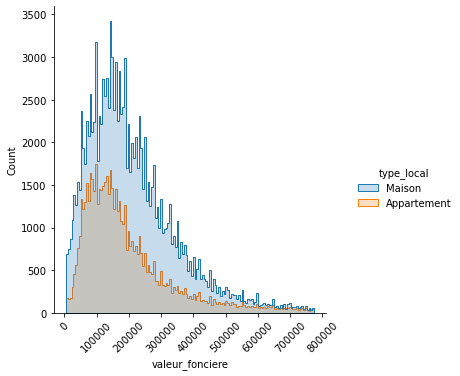

In [36]:
data_aux = data_aux.drop(data_aux.loc[data_aux['type_local'] == 'Local industriel. commercial ou assimilé'].index)

sns.displot(data = data_aux,
            x = "valeur_fonciere",
            hue = "type_local",
            element = "step")

plt.xticks(rotation = 45)
plt.show()

On constate que **les valeurs foncières des dépendances sont centrées autour de très faibles valeurs**, viennent ensuite les appartements puis les maisons (ce qui est logique).

### 3.3. Corrélation entre valeur foncière et surface :

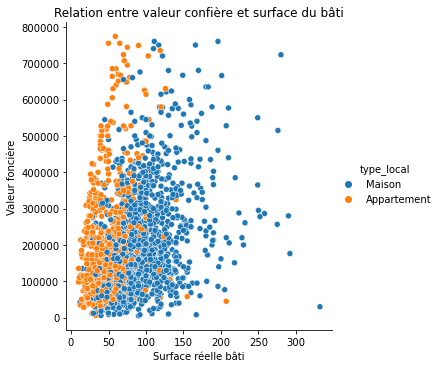

In [37]:
# Représentation des transactions d'appartements et maisons : valeur foncière en fonction de la surface

data_aux = data_aux.drop(data_aux.loc[data_aux['type_local'] == 'Dépendance'].index)

ax = sns.relplot(x = "surface_reelle_bati", 
            y = "valeur_fonciere", 
            hue = "type_local", 
            data = data_aux.sample(2000))
ax.set(title = "Relation entre valeur confière et surface du bâti",
       xlabel = "Surface réelle bâti", ylabel = "Valeur foncière")
plt.show()

# Lien tuto seaborn : https://ichi.pro/fr/maitriser-la-visualisation-de-donnees-en-python-avec-seaborn-224185530768080

On ne constate **pas une corrélation très marquée**... En effet, il faudrait **distinguer la localisation** du bien (Paris vs. petite ville vs. campagne).

### 3.4. Premières intuitions sur l'analyse à l'échelle départementale :

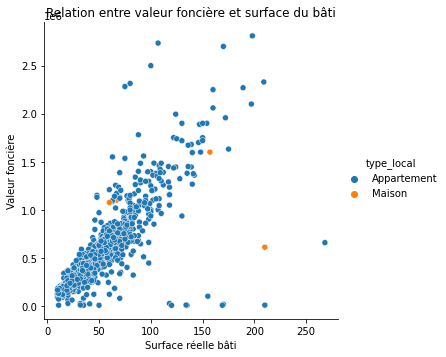

In [38]:
# Représentation des transactions d'appartements et maisons pour Paris

data_aux_paris = data.drop(data.loc[data['code_departement'] != 75].index)
data_aux_paris = data_aux_paris.drop(data_aux_paris.loc[data_aux_paris['type_local'] == 'Local industriel. commercial ou assimilé'].index)

ax = sns.relplot(x = "surface_reelle_bati", 
            y = "valeur_fonciere", 
            hue = "type_local", 
            data = data_aux_paris.sample(1000))
ax.set(title = "Relation entre valeur foncière et surface du bâti",
       xlabel = "Surface réelle bâti", ylabel = "Valeur foncière")
plt.show()

Observation de la corrélation :

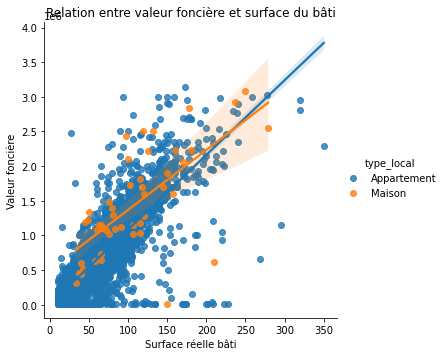

In [39]:
ax = sns.lmplot(x = "surface_reelle_bati", 
            y = "valeur_fonciere", 
            hue = "type_local", 
            data = data_aux_paris.sample(10000))
ax.set(title = "Relation entre valeur foncière et surface du bâti",
       xlabel = "Surface réelle bâti", ylabel = "Valeur foncière")
plt.show()

Pour la ville de Paris, la corrélation est très marquée !

(317, 15)

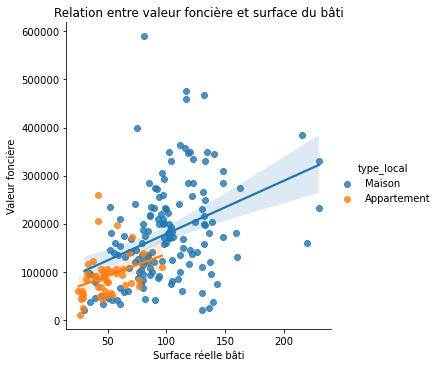

In [40]:
# Représentation des transactions d'appartements et maisons pour le Finistère

data_aux_finistere = data.drop(data.loc[data['code_departement'] != 29].index)
data_aux_finistere = data_aux_finistere.drop(data_aux_finistere.loc[data_aux_finistere['type_local'] == 'Local industriel. commercial ou assimilé'].index)
display(data_aux_finistere.shape)

ax = sns.lmplot(x = "surface_reelle_bati", 
            y = "valeur_fonciere", 
            hue = "type_local", 
            data = data_aux_finistere.sample(200))
ax.set(title = "Relation entre valeur foncière et surface du bâti",
       xlabel = "Surface réelle bâti", ylabel = "Valeur foncière")
plt.show()

### 3.5. Analyse par département :

In [41]:
# Plutôt chercher : les dix départements où il y a eu le plus / moins de ventes ...
# Sinon, on ne visualise pas grand chose !

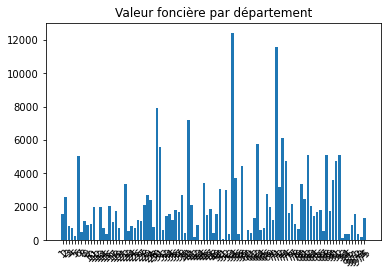

In [42]:
# Les transactions sont inégalement réparties dans les territoires : cela dépend logiquement de la densité de population.
# Il conviendrait d'avoir le nombre de transactions moyen par habitant par département...
# Cela permettrait de savoir si certains département sont plus dynamiques que d'autres au niveau immobilier.
# On ciblerait ainsi, par exemple, des phénomènes de bulle immobilière dans des départements touristiques non résidentiels

fig, axs = plt.subplots()
axs.set(title = "Valeur foncière par département")
axs.bar(x = [str(dep) for dep in data.code_departement.unique()],
            height = data.groupby("code_departement").valeur_fonciere.count() )
plt.xticks(rotation = 45)
plt.show()

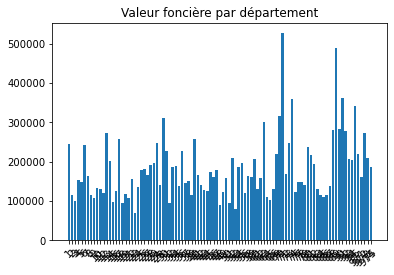

In [43]:
fig, axs = plt.subplots()
axs.set(title = "Valeur foncière par département")
axs.bar(x = [str(i) for i in data.code_departement.unique()],
            height = data.groupby("code_departement").valeur_fonciere.mean() )
plt.xticks(rotation = 45)
plt.show()

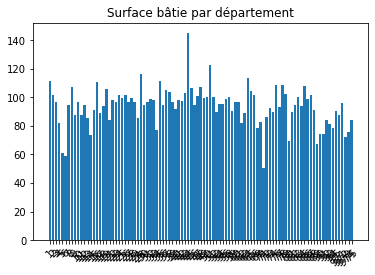

In [44]:
fig, axs = plt.subplots()
axs.set(title = "Surface bâtie par département")
axs.bar(x = [str(i) for i in data.code_departement.unique()],
            height = data.groupby("code_departement").surface_reelle_bati.mean() )
plt.xticks(rotation = 45)
plt.show()

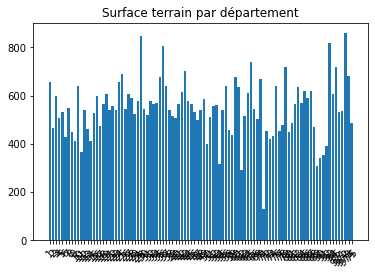

In [45]:
fig, axs = plt.subplots()
axs.set(title = "Surface terrain par département")
axs.bar(x = [str(i) for i in data.code_departement.unique()],
            height = data.groupby("code_departement").surface_terrain.mean() )
plt.xticks(rotation = 45)
plt.show()

### 3.6. QQ-plot :

Les QQ-plot pour la variable "valeurs foncières" correspondent à ceux d'une **distribution exponentielle**, ce qui confirme notre intuition sur la répartition des valeurs foncières.

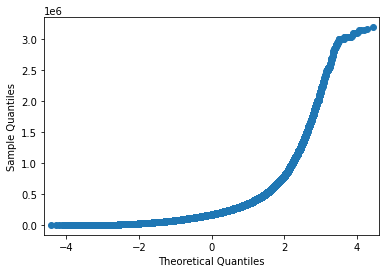

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

sm.qqplot(data["valeur_fonciere"])
plt.show()

((array([-4.50351935, -4.31138327, -4.20710567, ...,  4.20710567,
          4.31138327,  4.50351935]),
  array([   5000.,    5000.,    5000., ..., 3150000., 3169650., 3190000.])),
 (179346.30430657006, 227577.59916866344, 0.8202750522626525))

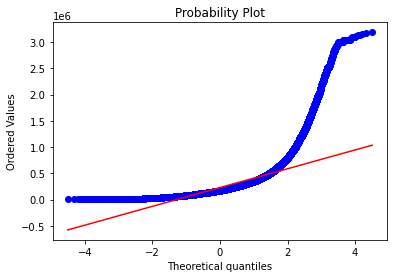

In [47]:
from scipy import stats

stats.probplot(data["valeur_fonciere"], plot = plt)

### 3.7. Représentation cartographique :

In [49]:
# Décommenter si packages pas installés

!pip install geopandas
import geopandas as gpd
!pip install folium
import folium

     |████████████████████████████████| 1.0 MB 1.7 MB/s            
     |████████████████████████████████| 15.4 MB 59.6 MB/s            
     |████████████████████████████████| 5.8 MB 13.2 MB/s            
     |████████████████████████████████| 1.1 MB 22.9 MB/s            
     |████████████████████████████████| 95 kB 1.5 MB/s            


In [192]:
sub_data = data[data['code_departement'] == 75]
sub_data = sub_data[sub_data['longitude'].notna()]
sub_data = sub_data[sub_data['latitude'].notna()]
sub_data = sub_data.sample(10).reset_index()

In [193]:
paris = folium.Map(location = [48.856578, 2.351828], zoom_start = 12)
folium.Marker([2.307332, 48.880394], popup = "test").add_to(paris)

for index in tqdm(range(sub_data.shape[0]), desc = "Progression"):
    coord = [float(sub_data["longitude"][index]), float(sub_data["latitude"][index])]
    folium.CircleMarker(coord, 
                        popup = sub_data["identifiant_transaction"][index], 
                        radius = 100).add_to(paris)

paris

Progression: 100%|██████████| 10/10 [00:00<00:00, 4742.01it/s]


In [194]:
sub_data = data[data['longitude'].notna()]
sub_data = sub_data[sub_data['latitude'].notna()]
sub_data = sub_data.sample(100).reset_index()

In [195]:
france = folium.Map(location = [46.227638, 2.213749], zoom_start = 5)

for index in tqdm(range(sub_data.shape[0]), desc = "Progression"):
    folium.CircleMarker([float(sub_data["longitude"][index]), float(sub_data["latitude"][index])], popup = sub_data["identifiant_transaction"][index], radius = 10).add_to(france)

france

Progression: 100%|██████████| 100/100 [00:00<00:00, 7219.11it/s]


In [ ]:
# lien tuto folium : https://fxjollois.github.io/cours-2016-2017/analyse-donnees-massives-tp9.html

# Etape 4 : modélisation

**Imports pour la modélisation**

In [217]:
from sklearn.metrics import make_scorer
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

In [218]:
# data_model = data[data["valeur_fonciere"] > 0.0] # A priori plus nécessaire car fait plus haut
data_model = data

**Concernant le choix des métriques d'évaluation des modèles** 
Ici on cherche à prédire le plus précisemment possible la valeur du logement à partir de ses caractéristiques.
Les métriques utilisées pour l'instant sont :
- *Explained_variance_score* qui correspond à la part de variance dans le y_pred que le modèle explique
- *mean_squarred_error* "expected value of the squarred error"
- MAPE codée en-dessous, mean absolute percentage error, mesure de la précision comme un pourcentage  

**Ce sera important de justifier notre choix de ces métriques**

In [220]:
# Features selection

features = ['valeur_fonciere', 'type_local', 'surface_reelle_bati', 'nombre_pieces_principales', 
            'nature_culture', 'surface_terrain', 'longitude', 'latitude', 'code_departement', 'prix_m2']

data_model = data_model[features]

Etant donné que le modèle de randomforest de sklearn ne peut pas gérer seul les variables catégorielles, nous devons les 
transformer en dummies

In [221]:
# Encoding categorical variables

# local_type

data_model["encoded_local_type_m"] = [1 if local == "Maison" else 0 for local in data_model["type_local"]]
data_model["encoded_local_type_a"] = [2 if local == "Appartement" else 0 for local in data_model["type_local"]]
data_model["encoded_local_type_d"] = [3 if local == "Dépendance" else 0 for local in data_model["type_local"]]
data_model["encoded_local_type_l"] = [4 if local == "Local industriel. commercial ou assimilé" else 0 \
                                      for local in data_model["type_local"]]


list_name = ["type_local", "encoded_local_type_m", "encoded_local_type_a", "encoded_local_type_d", 
             "encoded_local_type_l"]

data_model["encoded_local_type"] = data_model.loc[:,list_name].sum(axis = 1)
data_model = data_model.drop(list_name, axis = 1)

# nature_culture

data_model["encoded_nature_culture_c"] = [1 if local == "culture" else 0 for local in data_model["nature_culture"]]
data_model["encoded_nature_culture_s"] = [2 if local == "sols" else 0 for local in data_model["nature_culture"]]
data_model["encoded_nature_culture_tb"] = [3 if local == "terrains a bâtir" else 0 for local in data_model["nature_culture"]]
data_model["encoded_nature_culture_j"] = [4 if local == "jardins" else 0 for local in data_model["nature_culture"]]
data_model["encoded_nature_culture_ta"] = [4 if local == "terrains d'agrément" else 0 for local in data_model["nature_culture"]]

list_name = ["nature_culture", "encoded_nature_culture_c", "encoded_nature_culture_s", 
             "encoded_nature_culture_tb", "encoded_nature_culture_j", "encoded_nature_culture_ta"]

data_model["encoded_nature_culture"] = data_model.loc[:,list_name].sum(axis = 1)

data_model = data_model.drop(list_name, axis = 1)

# code_departement

data_model["code_departement"] = [201 if code == "2A" else code for code in data_model["code_departement"]]
data_model["code_departement"] = [202 if code == "2B" else code for code in data_model["code_departement"]]

# enlever NaN (on les remplace par des 0, à justifier)
data_model = data_model.fillna(0)

data_model.head()

/tmp/ipykernel_258/2054480169.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model["encoded_local_type_m"] = [1 if local == "Maison" else 0 for local in data_model["type_local"]]
/tmp/ipykernel_258/2054480169.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_model["encoded_local_type_a"] = [2 if local == "Appartement" else 0 for local in data_model["type_local"]]
/tmp/ipykernel_258/2054480169.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,code_departement,prix_m2,encoded_local_type,encoded_nature_culture
1,204332.0,88.0,4.0,866.0,5.157688,46.200988,1,0.004238,1,2
6,226700.0,96.0,3.0,0.0,5.108604,46.244066,1,0.000000,1,0
7,185000.0,100.0,4.0,703.0,5.210226,46.187698,1,0.003800,1,2
8,114500.0,85.0,2.0,87.0,5.174845,46.368874,1,0.000760,1,2
10,145000.0,92.0,1.0,2480.0,5.200760,46.405032,1,0.017103,1,2


**Régression linéaire simple**

In [238]:
data_model_small = data_model.copy()
data_model_small.head()

,valeur_fonciere,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,code_departement,prix_m2,encoded_local_type,encoded_nature_culture
1,204332.0,88.0,4.0,866.0,5.157688,46.200988,1,0.004238,1,2
6,226700.0,96.0,3.0,0.0,5.108604,46.244066,1,0.000000,1,0
7,185000.0,100.0,4.0,703.0,5.210226,46.187698,1,0.003800,1,2
8,114500.0,85.0,2.0,87.0,5.174845,46.368874,1,0.000760,1,2
10,145000.0,92.0,1.0,2480.0,5.200760,46.405032,1,0.017103,1,2


In [239]:
data_model_small = data_model_small[["surface_reelle_bati", "valeur_fonciere"]]
data_model_small.head()

,surface_reelle_bati,valeur_fonciere
1,88.0,204332.0
6,96.0,226700.0
7,100.0,185000.0
8,85.0,114500.0
10,92.0,145000.0


In [240]:
# Entraînement du modèle régression linéaire simple

training_data, test_data = train_test_split(data_model_small, test_size = 0.2)
y_train = training_data["valeur_fonciere"].values
X_train = training_data.drop(["valeur_fonciere"], axis = 1).values

model = LinearRegression(fit_intercept = True).fit(X_train, y_train)

In [241]:
# Test du modèle régression linéaire simple

y_test = test_data["valeur_fonciere"].values
X_test = test_data.drop(["valeur_fonciere"], axis = 1).values
y_pred = model.predict(X_test)

In [242]:
# Coefficients du modèle régression linéaire simple

print("Intercept: \n", model.intercept_)
print("Coefficients: \n", model.coef_)

Intercept: 
 163626.9388226966
Coefficients: 
 [713.70952539]


In [243]:
# Métriques du modèle régression linéaire simple

display("Variance expliquée par le modèle régression linéaire simple :")
display(explained_variance_score(y_test, y_pred))

display("MAPE")
display(mean_absolute_percentage_error(y_test, y_pred))

display("MSE")
display(mean_squared_error(y_test, y_pred))

display("R2")
display(r2_score(y_test, y_pred))

'Variance expliquée par le modèle régression linéaire simple :'

0.0742733887331426

'MAPE'

1.1651850115769287

'MSE'

42418280253.517426

'R2'

0.07421181847953318

Ce modèle extrêmement simple explique seulement **7%** de la variance dans les données de test

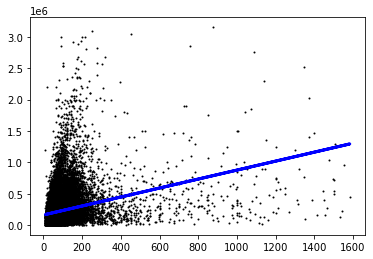

In [244]:
fig, axs = plt.subplots()
axs.scatter(X_test, y_test, color = "black", s = 1)
axs.plot(X_test, y_pred, color = "blue", linewidth = 3)
plt.show()

Le graphique ci-dessus indique les vrais points de données (en noir) et la droite de la régression linéaire simple (en bleue)

**Régression linéaire multiple**

In [245]:
# Entraînement du modèle régression linéaire multiple

# code_departement ? Pas ajoutable en l'état parce qu'il induirait un ordre entre le départemetn ce qui n'est pas ce qu'on veut

training_data, test_data = train_test_split(data_model[["valeur_fonciere","surface_reelle_bati", "nombre_pieces_principales",
                                                       "surface_terrain", "encoded_local_type", "encoded_nature_culture"]],
                                            test_size = 0.2)

y_train = training_data["valeur_fonciere"].values
X_train = training_data.drop(["valeur_fonciere"], axis = 1).values

model = LinearRegression(fit_intercept = True).fit(X_train, y_train)

In [246]:
# Test du modèle régression linéaire multiple

y_test = test_data["valeur_fonciere"].values
X_test = test_data.drop(["valeur_fonciere"], axis = 1).values
y_pred = model.predict(X_test)

In [247]:
# Coefficients du régression linéaire multiple
print("Intercept: \n", model.intercept_)
print("Coefficients: \n", model.coef_)

Intercept: 
 46984.36645415367
Coefficients: 
 [ 6.45682740e+02  3.47171669e+04  2.12498845e+00  2.92650196e+04
 -3.15034526e+04]


In [248]:
# Métriques du modèle régression linéaire multiple

display("Variance expliquée par le modèle régression linéaire multiple :")
display(explained_variance_score(y_test, y_pred))

display("MAPE")
display(mean_absolute_percentage_error(y_test, y_pred))

display("MSE")
display(mean_squared_error(y_test, y_pred))

display("R2")
display(r2_score(y_test, y_pred))

'Variance expliquée par le modèle régression linéaire multiple :'

0.12165569092752204

'MAPE'

1.0385680539532387

'MSE'

40544873012.89889

'R2'

0.12162717005325119

Dans mon test, on monte à seulement **12 %** de variance expliquée en rajoutant plein de variables

**Random forest**

In [249]:
# Entraînement du modèle random forest

training_data, test_data = train_test_split(data_model, test_size = 0.2)

y_train = training_data["valeur_fonciere"].values
X_train = training_data.drop(["valeur_fonciere", "prix_m2"], axis = 1).values

model = RandomForestRegressor(n_estimators = 30, min_samples_split = 5)

model.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=5, n_estimators=30)

In [250]:
# Test du modèle random forest

y_test = test_data["valeur_fonciere"].values
X_test = test_data.drop(["valeur_fonciere", "prix_m2"], axis = 1).values
y_pred = model.predict(X_test)

display("Variance expliquée par le modèle")
display(explained_variance_score(y_test, y_pred))

'Variance expliquée par le modèle'

0.6719989481999924

In [251]:
# Métriques du modèle random forest

display("Variance expliquée par le modèle random forest :")
display(explained_variance_score(y_test, y_pred))

display("MAPE")
display(mean_absolute_percentage_error(y_test, y_pred))

display("MSE")
display(mean_squared_error(y_test, y_pred))

display("R2")
display(r2_score(y_test, y_pred))

'Variance expliquée par le modèle random forest :'

0.6719989481999924

'MAPE'

0.543144686108614

'MSE'

15628024095.446463

'R2'

0.6719598145920428

Text(0.5, 1.0, "Distribution de l'erreur de notre modèle")

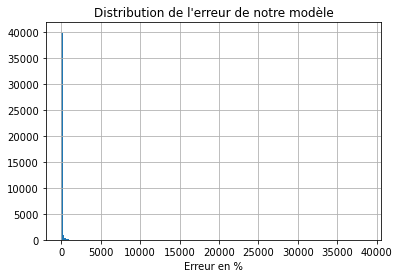

In [252]:
schema = pd.DataFrame((np.abs(y_test - model.predict(X_test)) / y_test)) * 100

schema.hist(bins = 200)

plt.xlabel('Erreur en %')
plt.title('Distribution de l\'erreur de notre modèle')